# Hallway Data Set Analysis and Machine Learning

## Problem Definition

In the data set here analysed we have the usage data for a hardware module installed in a hallway, with data that was captured for around a month. Our objective here is to train a model that will be able to accurately predict whenever the user would like to have the light of the hallway activated.

This is a Machine Learning problem that falls into the category of supervised learning, for a classification algorithm.

## Data Analysis

This will be the first step on the search for a good Machine Learning algorithm to be applied on our data set.

Our data set consists of data captured from 20/09/2017 til 29/10/2017, on a hallway. Both relays were connected to lights. Relay 1's light was on the same environment to which the luminosity sensor was placed.

The following parameters is what we have for each data entry:
- date/time
- luminosity
- temperature
- humidity
- presence
- relay activation
- type of activation (via button, website, remote control or automatic scheduling)
- relay status

In [1]:
# Importing basic libraries for Data Science and Machine Learning

import datetime
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
import matplotlib

In [2]:
# Set styles for our graphs that are going to be plotted

sns.set_style('whitegrid')
        
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160

In [3]:
# Define helper functions

def to_seconds(time):
    [hours, minutes, seconds] = [int(x) for x in time.split(':')]
    x = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    return x.seconds

def was_activated(activation):
    if activation == 1:
        return True
    return False

def get_presence_as_binary(presence_data):
    if presence_data == 1:
        return presence_data
    return 0

In [4]:
ml_data_path = 'hallway_data_set.csv'
ml_data = pd.read_csv(ml_data_path)

print(len(ml_data))

10736


In [5]:
# Checkout data structure

print(ml_data.iloc[0])

Dado Bruto Unix Time                 1505942761 Rele1: 1
Dado Bruto DateTime                      20/9/17 18:26:1
Dado Bruto                  20/09/2017 18:26:01 Rele1: 1
Data                                          20/09/2017
Hora                                            18:26:01
Info                                            Rele1: 1
ChipId                                               NaN
Versao =                                         170915b
Unnamed: 8                                             0
localPingErrCnt:                                     NaN
WiFi Conectando                                        0
WL_DISCONNECTED                                      NaN
minFreeHeap                                          NaN
ms                                                   NaN
NTP Server                                             0
TimeNTP                                                0
tempo para conexão (s)                                 0
myip[                          

3766
6970


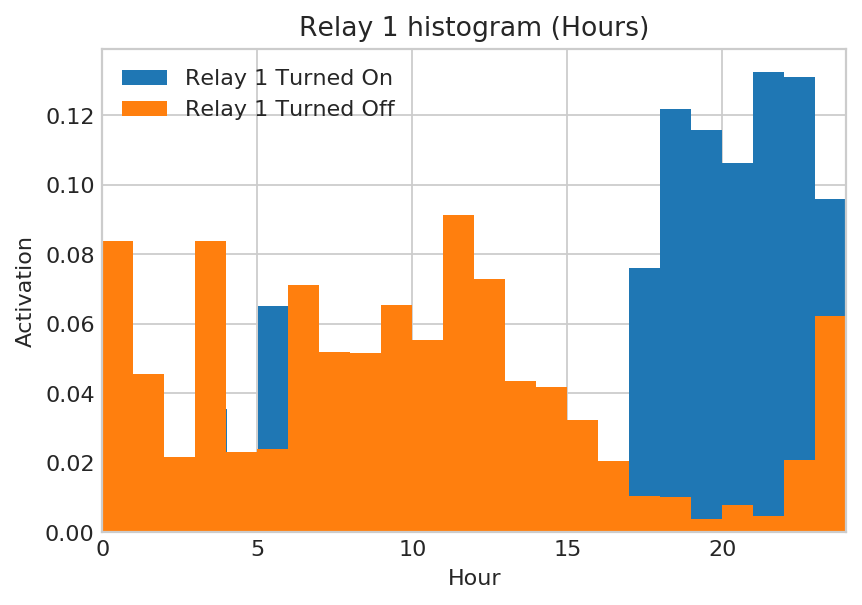

In [36]:
# Begin some data analysis

rele1_hours_turned_on = [ to_seconds(data[4])/3600 for index, data in ml_data.iterrows() if data['Rele1'] == 1]
rele1_hours_turned_off = [ to_seconds(data[4])/3600 for index, data in ml_data.iterrows() if data['Rele1'] == 0]
print(len(rele1_hours_turned_on))
print(len(rele1_hours_turned_off))

assert len(ml_data) == len(rele1_hours_turned_on) + len(rele1_hours_turned_off)

plt.xlim(0, 24)
plt.hist(rele1_hours_turned_on, bins=24, normed=True, label = 'Relay 1 Turned On')
plt.hist(rele1_hours_turned_off, bins=24, normed=True, label = 'Relay 1 Turned Off')
plt.title('Relay 1 histogram (Hours)')
plt.xlabel('Hour')
plt.ylabel('Activation')
plt.legend()
plt.show()

In [38]:
features = []
features_turn_on = []
features_not_turn_on = []
activation_bool = []

for index, data in ml_data.iterrows():
    # we do not want to consider it if the light was already on, or if the activation was automatic (scheduled)
    if index == 0 or ml_data.iloc[index-1]['Rele1'] == 1 or ml_data.iloc[index-1]['Auto1Activation'] == 1:
        continue
    
    # will discard nan values
    if np.isnan(data['LumValue']) or np.isnan(data['TempValue']) or np.isnan(data['HumValue']):
        continue
    
    features.append([to_seconds(data[4]),
                     data['LumValue'],
                     data['TempValue'],
                     data['HumValue'],
                     get_presence_as_binary(data['S1Activation']),
                    ]) 
    activation_bool.append(was_activated(data['Rele1Activation']))
    
    if activation_bool[-1]:
        features_turn_on.append(features[-1])
    else:
        features_not_turn_on.append(features[-1])

assert len(features) == len(activation_bool)

features = np.array(features)
activation_bool = np.array(activation_bool)

count_yes = 0
count_no = 0
for item in activation_bool:
    if item:
        count_yes += 1
    else:
        count_no += 1
        
print('Count of activations: ' + str(count_yes))
print('Count of not activations: ' + str(count_no))
print("Percentage of activations: {0:.2f}%".format(((count_yes)/len(activation_bool)) * 100))

Count of activations: 71
Count of not activations: 6851
Percentage of activations: 1.03%


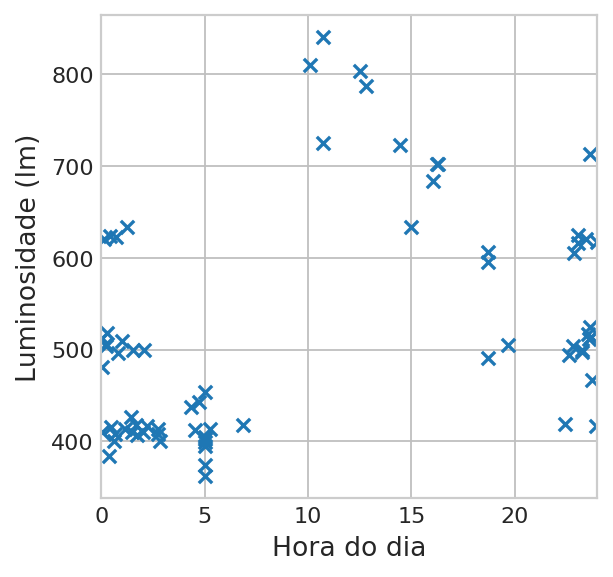

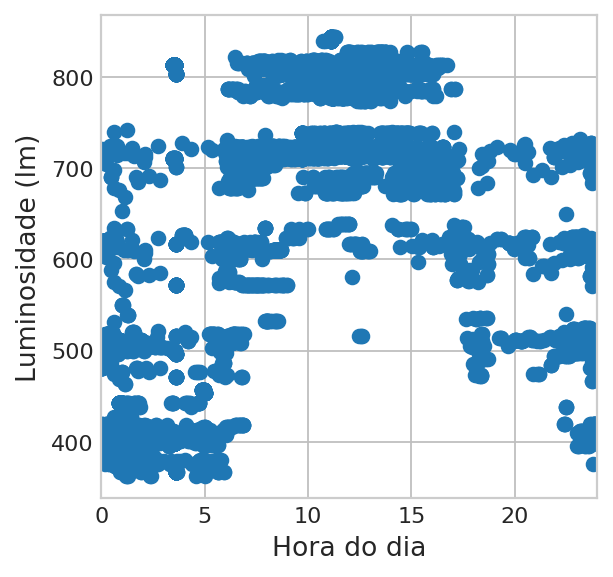

In [41]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_turn_on)[:, 0]/3600, 
           np.array(features_turn_on)[:, 1], 
           marker = 'x');

plt.show()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_not_turn_on)[:, 0]/3600, 
           np.array(features_not_turn_on)[:, 1], 
           marker = 'o');

plt.show()

## Model Training

Here we begin training some models to see how well they perform on our problem.

All the models are based on classification algorithms for supervised learning situations.

The models selected for our analysis are:
- Logistic Regression
- Linear Discriminant Analysis
- K-Nearest Neighbors

In [42]:
# importing helper libs
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# importing ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

classifiers = [LogisticRegression(),
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier()]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, activation_bool, test_size=0.33)


metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train, y_train)
    
    # here we test
    y_pred = model.predict(X_test)
    
    # here we check performance
    report = classification_report(y_test, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train, y_train),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

from pprint import pprint
pprint([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]
print('\nBest classifier is {}'.format(best_clf.__class__.__name__))
print(metrics[0][3])

[('LogisticRegression', 0.98949671772428882, 0.98986413629501835),
 ('LinearDiscriminantAnalysis', 0.98949671772428882, 0.98986413629501835),
 ('KNeighborsClassifier', 0.98862144420131293, 0.99029544964416649)]

Best classifier is LogisticRegression
             precision    recall  f1-score   support

      False       0.99      1.00      0.99      2261
       True       0.00      0.00      0.00        24

avg / total       0.98      0.99      0.98      2285



## Addressing the Class Imbalance problem

As we found out, the percentage of data rows that correspond to relay 1's activation is only 1% of the data we have. This large difference between classes is known as the Class Imbalance problem, and must be addressed.

In [17]:
# analysing current situation

from collections import Counter
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(activation_bool).items()))

[(False, 4592), (True, 45)]
[(False, 2259), (True, 26)]
[(False, 6851), (True, 71)]


In [44]:
# applying random over sampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_sample(X_train, y_train)

print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_train_resampled).items()))

[(False, 4590), (True, 47)]
[(False, 2261), (True, 24)]
[(False, 4590), (True, 4590)]


In [45]:
features_turn_on = []

index = 0
for data in np.array(y_train_resampled):
    if data:
        features_turn_on.append(X_train_resampled[index])
    index += 1

print(len(features_turn_on))

4590


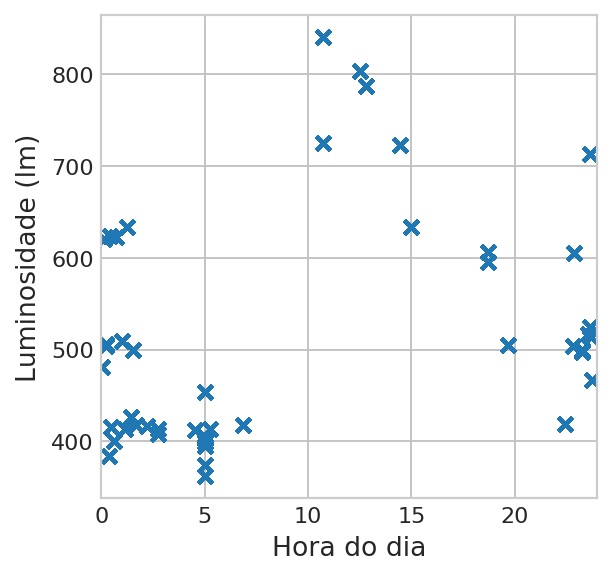

In [46]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_turn_on)[:, 0]/3600, 
           np.array(features_turn_on)[:, 1], 
           marker = 'x');

plt.show()


In [47]:
metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train_resampled, y_train_resampled)
    
    # here we test
    y_pred = model.predict(X_test)
    
    # here we check performance
    report = classification_report(y_test, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train_resampled, y_train_resampled),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

from pprint import pprint
pprint([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]
print('\nBest classifier is {}'.format(best_clf.__class__.__name__))
print(metrics[0][3])

[('KNeighborsClassifier', 0.96017505470459519, 0.98867102396514162),
 ('LogisticRegression', 0.72253829321663021, 0.76470588235294112),
 ('LinearDiscriminantAnalysis', 0.71859956236323852, 0.77265795206971677)]

Best classifier is KNeighborsClassifier
             precision    recall  f1-score   support

      False       0.99      0.97      0.98      2261
       True       0.00      0.00      0.00        24

avg / total       0.98      0.96      0.97      2285



In [48]:
# over sampling with SMOTE technique

from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_train_resampled).items()))

[(False, 4590), (True, 47)]
[(False, 2261), (True, 24)]
[(False, 4590), (True, 4590)]


In [49]:
features_turn_on = []

index = 0
for data in np.array(y_train_resampled):
    if data:
        features_turn_on.append(X_train_resampled[index])
    index += 1

print(len(features_turn_on))

4590


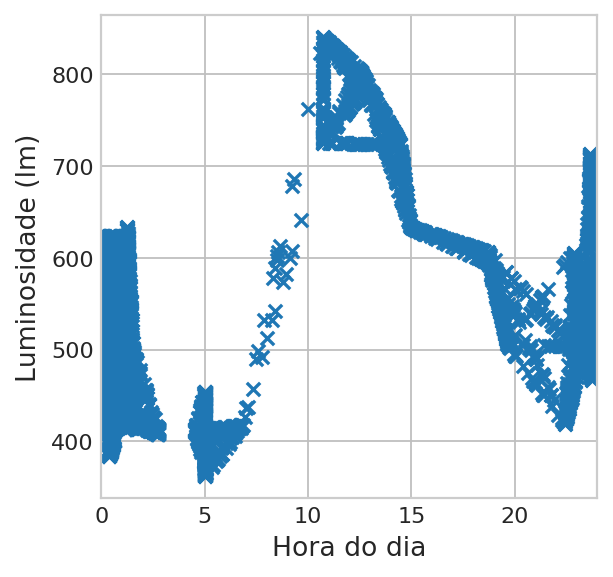

In [50]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_turn_on)[:, 0]/3600, 
           np.array(features_turn_on)[:, 1], 
           marker = 'x');

plt.show()


In [51]:
metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train_resampled, y_train_resampled)
    
    # here we test
    y_pred = model.predict(X_test)
    
    # here we check performance
    report = classification_report(y_test, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train_resampled, y_train_resampled),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

from pprint import pprint
pprint([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]
print('\nBest classifier is {}'.format(best_clf.__class__.__name__))
print(metrics[0][3])

[('KNeighborsClassifier', 0.8144420131291028, 0.89694989106753809),
 ('LogisticRegression', 0.73085339168490149, 0.78366013071895424),
 ('LinearDiscriminantAnalysis', 0.72297592997811821, 0.79041394335511983)]

Best classifier is KNeighborsClassifier
             precision    recall  f1-score   support

      False       0.99      0.82      0.90      2261
       True       0.01      0.21      0.02        24

avg / total       0.98      0.81      0.89      2285



In [52]:
# applying under sampling

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)

X_train_resampled, y_train_resampled = cc.fit_sample(X_train, y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_train_resampled).items()))

[(False, 4590), (True, 47)]
[(False, 2261), (True, 24)]
[(False, 47), (True, 47)]


In [53]:
features_turn_on = []

index = 0
for data in np.array(y_train_resampled):
    if data:
        features_turn_on.append(X_train_resampled[index])
    index += 1

print(len(features_turn_on))

47


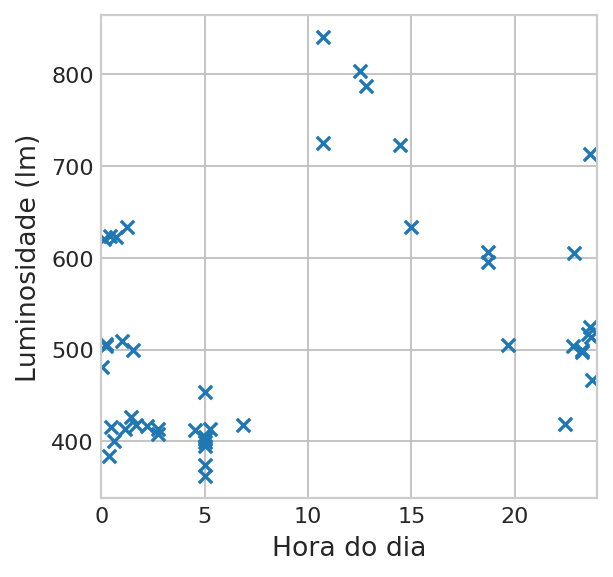

In [54]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_turn_on)[:, 0]/3600, 
           np.array(features_turn_on)[:, 1], 
           marker = 'x');

plt.show()


In [55]:
metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train_resampled, y_train_resampled)
    
    # here we test
    y_pred = model.predict(X_test)
    
    # here we check performance
    report = classification_report(y_test, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train_resampled, y_train_resampled),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

from pprint import pprint
pprint([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]
print('\nBest classifier is {}'.format(best_clf.__class__.__name__))
print(metrics[0][3])

[('KNeighborsClassifier', 0.72341356673960611, 0.75531914893617025),
 ('LogisticRegression', 0.6796498905908096, 0.67021276595744683),
 ('LinearDiscriminantAnalysis', 0.34835886214442013, 0.96808510638297873)]

Best classifier is KNeighborsClassifier
             precision    recall  f1-score   support

      False       1.00      0.72      0.84      2261
       True       0.03      0.83      0.06        24

avg / total       0.99      0.72      0.83      2285



In [56]:
# applying both over and under sampling

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)

X_train_resampled, y_train_resampled = smote_enn.fit_sample(X_train, y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_train_resampled).items()))

[(False, 4590), (True, 47)]
[(False, 2261), (True, 24)]
[(False, 3174), (True, 3257)]


In [57]:
features_turn_on = []

index = 0
for data in np.array(y_train_resampled):
    if data:
        features_turn_on.append(X_train_resampled[index])
    index += 1

print(len(features_turn_on))

3257


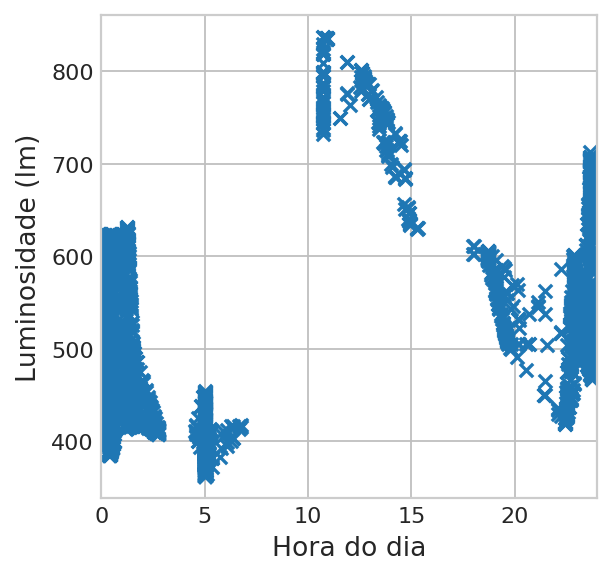

In [58]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hora do dia",fontsize=12)
ax.set_ylabel("Luminosidade (lm)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(np.array(features_turn_on)[:, 0]/3600, 
           np.array(features_turn_on)[:, 1], 
           marker = 'x');

plt.show()

In [59]:
metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train_resampled, y_train_resampled)
    
    # here we test
    y_pred = model.predict(X_test)
    
    # here we check performance
    report = classification_report(y_test, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train_resampled, y_train_resampled),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

from pprint import pprint
pprint([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]
print('\nBest classifier is {}'.format(best_clf.__class__.__name__))
print(metrics[0][3])

[('KNeighborsClassifier', 0.79037199124726476, 0.98833773907634892),
 ('LogisticRegression', 0.74048140043763677, 0.84745762711864403),
 ('LinearDiscriminantAnalysis', 0.72472647702407, 0.84372570362307575)]

Best classifier is KNeighborsClassifier
             precision    recall  f1-score   support

      False       0.99      0.79      0.88      2261
       True       0.02      0.38      0.04        24

avg / total       0.98      0.79      0.87      2285



## Conclusions

From the analysis so far, K-Nearest  Neighbors with random oversampling seems to have produced the most accurate prediction model. 

However, it is worth noting that this analysis could keep going on, changing techniques and algorithms, in a continuous search for an improved model. It is also worth mentioning that the algorithm could also keep getting trained with the acquisition of new usage data.